In [2]:
import torch
import torchsummary
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2

import os
import math
import glob

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
########################################
#           Hyperparameters            #
########################################

NUM_EPOCHS = 200
BATCH_SIZE = 128
IMG_SIZE = 256


rng = np.random.default_rng()

In [ ]:
import numpy as np
import torch
import glob
import math
from PIL import Image
from torchvision import transforms
from torch.utils.data import TensorDataset

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load the data with all of the classes
root = "/content/drive/MyDrive/CUB_200_2011/CUB_200_2011/images"
data_files = glob.glob(root + '/**/*.jpg', recursive=True)

# Apply the transformations to the images and create a list of tensors
data_tensors = [transform(Image.open(file)) for file in data_files]

# Create corresponding labels (assuming there's only one class in this case)
labels_tensor = torch.zeros(len(data_tensors), dtype=torch.long)

# Create TensorDataset from data and labels
dataset = TensorDataset(torch.stack(data_tensors), labels_tensor)

# Get the indices for the train/val/test split of 75/15/15
total_samples = len(dataset)
train_split = int(0.75 * total_samples)
val_split = int(0.15 * total_samples)
test_split = total_samples - train_split - val_split

# Make sure the splits are correct
assert train_split + val_split + test_split == len(dataset)

# Split the dataset randomly
generator = torch.Generator().manual_seed(1)
train, val, test = torch.utils.data.random_split(dataset, [train_split, val_split, test_split], generator=generator)

print(len(train), len(val), len(test))


In [12]:
print(data_dirs)

[]


In [ ]:
class GenData(torch.utils.data.Dataset):
    '''
    Data set class to store the feature maps
    '''

    def __init__(self, data, transform=None):
        # data = np.array(in_data)
        self.input_dirs = data
        self.transform = transform

        size = len(self.input_dirs) // 2

        # Number of sources and targets must be the same
        assert size % 2 == 0

        self.sources = self.input_dirs[:size]
        self.targets = self.input_dirs[size:]


    def __len__(self):
        return len(self.sources)

    def read_img(self, dir):
        img = cv2.imread(dir)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        return img

    def __getitem__(self, idx):

        source_dir = self.input_dirs[idx][0]
        target_dir = self.input_dirs[idx][1]

        source = self.read_img(source_dir)
        target = self.read_img(target_dir)

        if self.transform:
            source = self.transform(source)
            target = self.transform(target)

        return source, target

# Create data loaders
def get_data_loaders(batch_size=1):

    train_data = GenData(data_dirs[train.indices], transform=transform)
    val_data = GenData(data_dirs[val.indices], transform=transform)
    test_data = GenData(data_dirs[test.indices], transform=transform)

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader

In [ ]:
train_loader, valid_loader, test_loader = get_data_loaders(batch_size=BATCH_SIZE)

In [ ]:
# Checking the dataset


# Checking the dataset
print('Validation Set:\n')
for images, labels in valid_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

print('\nTraining Set:')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

Validation Set:


Testing Set:


Image batch dimensions: torch.Size([50, 3, 256, 256])
Image label dimensions: torch.Size([50, 3, 256, 256])

Training Set:
Image batch dimensions: torch.Size([128, 3, 256, 256])
Image label dimensions: torch.Size([128, 3, 256, 256])


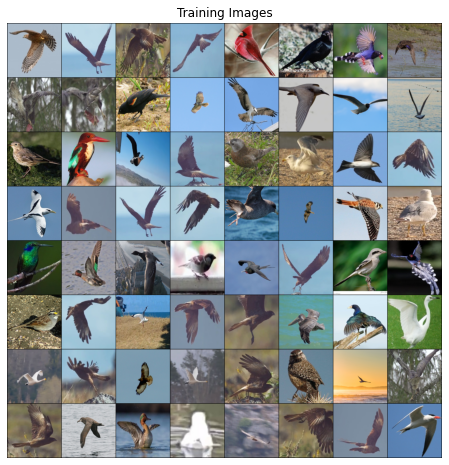

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Source Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64],
                                         padding=2, normalize=False),
                        (1, 2, 0)))

<h1>Model</h1>


In [ ]:
class Discriminator(nn.Module):

  def __init__(self, latent_dim=100,
                 num_feat_maps_gen=64, num_feat_maps_dis=64,
                 color_channels=3):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
            #
            # input size color_channels x image_height x image_width
            #
            nn.Conv2d(color_channels, num_feat_maps_dis,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis x 32 x 32
            #
            nn.Conv2d(num_feat_maps_dis, num_feat_maps_dis*2,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*2),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*2 x 16 x 16
            #
            nn.Conv2d(num_feat_maps_dis*2, num_feat_maps_dis*4,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*4 x 8 x 8
            #
            nn.Conv2d(num_feat_maps_dis*4, num_feat_maps_dis*8,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),
            nn.BatchNorm2d(num_feat_maps_dis*8),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*8 x 4 x 4
            #
            nn.Conv2d(num_feat_maps_dis*8, 1,
                      kernel_size=4, stride=1, padding=0),

            # size: 1 x 1 x 1
            nn.Flatten(),
    )

  def forward(self, img):
    logits = self.model(img)
    return logits


class Generator(nn.Module):

  def __init__(self, latent_dim=100,
                 num_feat_maps_gen=64, num_feat_maps_dis=64,
                 color_channels=3):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, num_feat_maps_gen*8,
                               kernel_size=4, stride=1, padding=0,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*8),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*8 x 4 x 4
            #
            nn.ConvTranspose2d(num_feat_maps_gen*8, num_feat_maps_gen*4,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*4),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*4 x 8 x 8
            #
            nn.ConvTranspose2d(num_feat_maps_gen*4, num_feat_maps_gen*2,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*2),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*2 x 16 x 16
            #
            nn.ConvTranspose2d(num_feat_maps_gen*2, num_feat_maps_gen,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen x 32 x 32
            #
            nn.ConvTranspose2d(num_feat_maps_gen, color_channels,
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            #
            # size: color_channels x 64 x 64
            #
            nn.Tanh()
        )

  def forward(self, z):
    img = self.model(z)
    return img

class CycleGAN(nn.Module):
    def __init__(self):
      # Initialize the generators and discriminators
      self.G_AB = Generator()
      self.G_BA = Generator()
      self.D_A = Discriminator()
      self.D_B = Discriminator()

    def forward(self, real_A, real_B):
      fake_B = self.G_AB(real_A)

      fake_A = self.G_BA(real_B)

      cycled_A = self.G_BA(fake_B)
      cycled_B = self.G_AB(fake_A)

      return fake_B, fake_A, cycled_A, cycled_B


<h1> Training</h1>